# DeepSEM

In [3]:
! lamin load jkobject/scprint

→ connected lamindb: jkobject/scprint


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GNInfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3
from grnndata import utils as grnutils
from anndata.utils import make_index_unique
import pandas as pd
import numpy as np

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
from grnndata import GRNAnnData

import sys
sys.path.append("../tools/DeepSEM")

from src.DeepSEM_cell_type_test_specific_GRN_model import celltype_GRN_model as test_celltype_GRN_model

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

import scipy.sparse

def run_deepsem(adata):
    import random
    import string

    def generate_random_hash(length=3):
        """Generate a random hash of specified length."""
        characters = string.ascii_letters + string.digits
        return ''.join(random.choice(characters) for _ in range(length))

    random_hash = generate_random_hash()
    opt = DotDict({
        'beta': 0.01,
        'alpha': 1,
        'K1': 1,
        'K2': 2,
        'K': 1,
        'net_file': "",
        'n_epochs': 50,
        'n_hidden': 128,
        'gamma': 0.95,
        'lr': 1e-4,
        'lr_step_size': 0.99,
        'batch_size': 64,
        'data_file': "/tmp/deepsem_"+random_hash+".h5ad",
        'save_name': "/tmp/deepsem/",
        'task': "celltype_GRN"
    })
    print(random_hash)
    if scipy.sparse.issparse(adata.X):
        adata.X = adata.X.toarray()
    adata.write("/tmp/deepsem_"+random_hash+".h5ad")
    model = test_celltype_GRN_model(opt)
    net = model.train_model()
    grn = GRNAnnData(adata.copy(), grn=net)
    del net
    return grn

In [3]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

650

In [4]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [5]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
NUM_GENES = 5000
NUM_CELLS = 1024
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 1 genes.
startin QC
Seeing 10066 outliers (94.15% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

precision:  0.021462814026651896 
recall:  0.6529636377597677 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:09<00:00, 12.85it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:10<00:00, 12.74it/s]


Average Precision (AP):  0.030823114022404265
Area Under Precision-Recall Curve (AUPRC):  0.029202769157061895
EPR: 2.8361441109211505


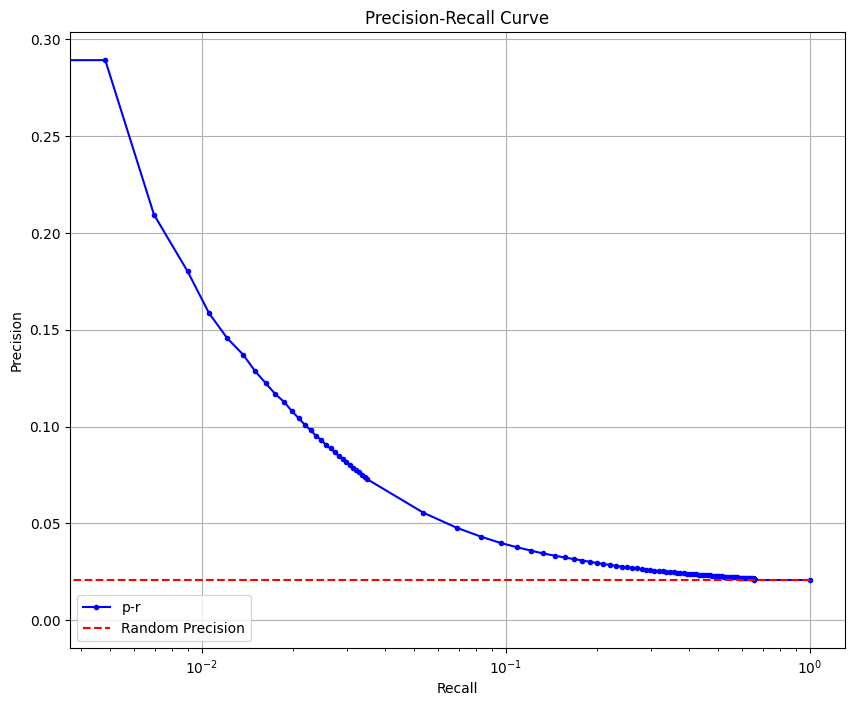

{'precision': 0.021462814026651896,
 'recall': 0.6529636377597677,
 'rand_precision': 0.020718126571001305,
 'auprc': 0.029202769157061895,
 'ap': 0.030823114022404265,
 'epr': 2.8361441109211505}

: 

In [23]:
#import regdiffusion as rd

#rd_trainer = rd.RegDiffusionTrainer(subadata.X.toarray())
#rd_trainer.train()
#grn = rd_trainer.get_adj()
#BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)grn.var.index = subadata.var.index
#BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1_000, adata.var.index.isin(
    genes) & adata.var.highly_variable]
del subadata.varp['GRN']
metrics = {}

In [7]:
sc.pp.normalize_total(subadata)
sc.pp.log1p(subadata)
sc.pp.scale(subadata, zero_center=True, max_value=None)


In [8]:
grn = run_deepsem(subadata)

sVV
save dir exist
epoch: 1 0.2298519005998969 mse_loss: 0.1932765105739236 kl_loss: 0.03581193523132242 sparse_loss: 0.000763449172154651
epoch: 2 0.1941153947263956 mse_loss: 0.1524191740900278 kl_loss: 0.040672194329090416 sparse_loss: 0.001024024069920415
epoch: 4 0.07877528388053179 mse_loss: 0.030273584299720824 kl_loss: 0.04739210149273276 sparse_loss: 0.0011095981099060737
epoch: 5 0.07827716786414385 mse_loss: 0.028846688102930784 kl_loss: 0.048285367083735764 sparse_loss: 0.0011451133759692311
epoch: 7 0.07656688382849097 mse_loss: 0.02600413851905614 kl_loss: 0.04940230050124228 sparse_loss: 0.0011604456376517192
epoch: 8 0.07621828559786081 mse_loss: 0.025566120631992817 kl_loss: 0.0494877117453143 sparse_loss: 0.0011644539627013728
epoch: 10 0.0747634107246995 mse_loss: 0.02397231012582779 kl_loss: 0.049626841209828854 sparse_loss: 0.0011642591998679563
epoch: 11 0.07469061482697725 mse_loss: 0.023984132567420602 kl_loss: 0.04954513208940625 sparse_loss: 0.0011613505994318

In [14]:
grn.varp['GRN'] = grn.varp['GRN'].T


precision:  0.020546889236634377 
recall:  0.9917349025849371 
random precision: 0.020718126571001305


 98%|█████████▊| 126/128 [00:05<00:00, 25.87it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:05<00:00, 25.12it/s]


Average Precision (AP):  0.028640612788292316
Area Under Precision-Recall Curve (AUPRC):  0.027343393364825698
EPR: 2.5105981197463576


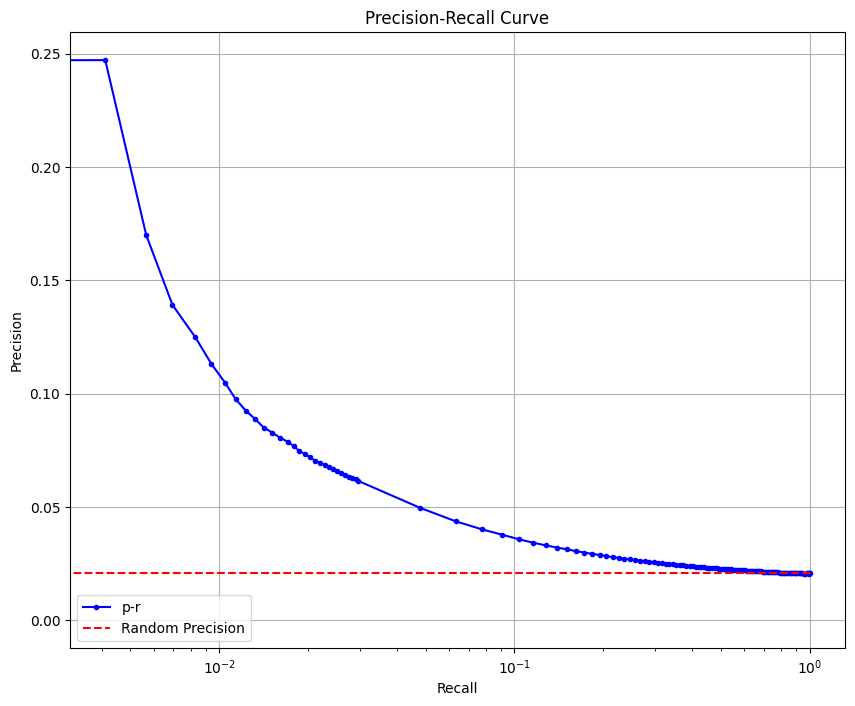

In [15]:
grn.var.index = subadata.var.index
metrics['deepsem_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
PowerIterationFailedConvergence


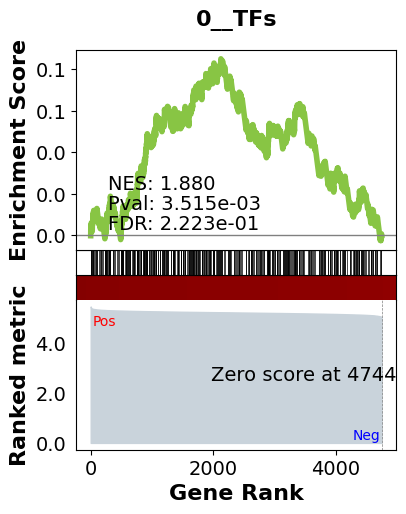

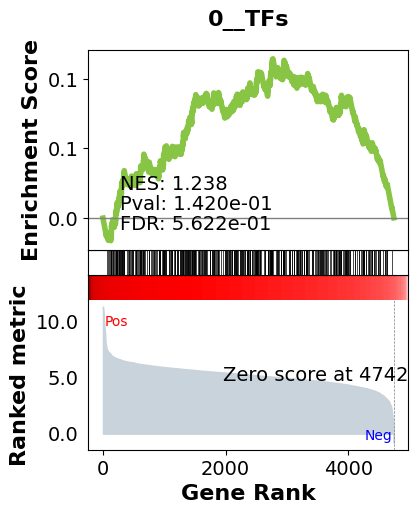

_________________________________________
TF specific enrichment
found some significant results for  8.928571428571429 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.00163245054093197 
recall:  0.99988483906259 
random precision: 0.0016326385571186594


 98%|█████████▊| 126/128 [00:01<00:00, 64.09it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 63.66it/s]


Average Precision (AP):  0.0018953259143821306
Area Under Precision-Recall Curve (AUPRC):  0.0018740760567549266
EPR: 3.952406498024029


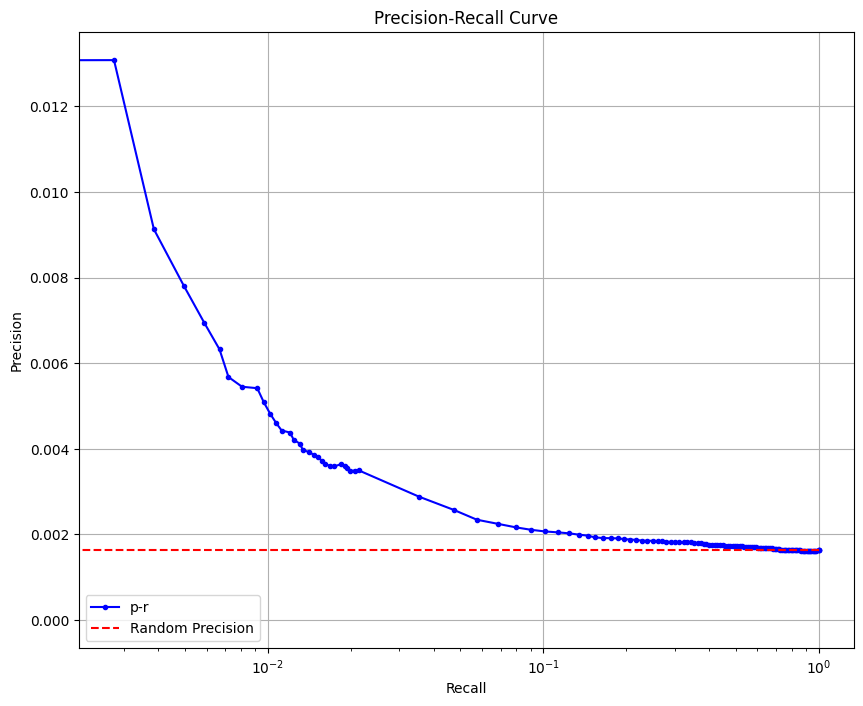

In [16]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
metrics['deepsem_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

# on TF only

In [17]:
# Set non-TF connections to 0
non_tf_mask = ~grn.var['isTF'].values
# Set connections to non-TFs to 0
grn.varp['GRN'][non_tf_mask, :] = 0

In [18]:
non_tf_mask = ~adata.var['isTF'].values
adata.varp['GRN'][non_tf_mask, :] = 0

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


precision:  0.015117780354131534 
recall:  0.9900166389351082 
random precision: 0.015270228559383281


 70%|███████   | 90/128 [00:00<00:00, 436.68it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 441.92it/s]


Average Precision (AP):  0.014894929059889175
Area Under Precision-Recall Curve (AUPRC):  0.014886158096796602
EPR: 0.9967125012335507


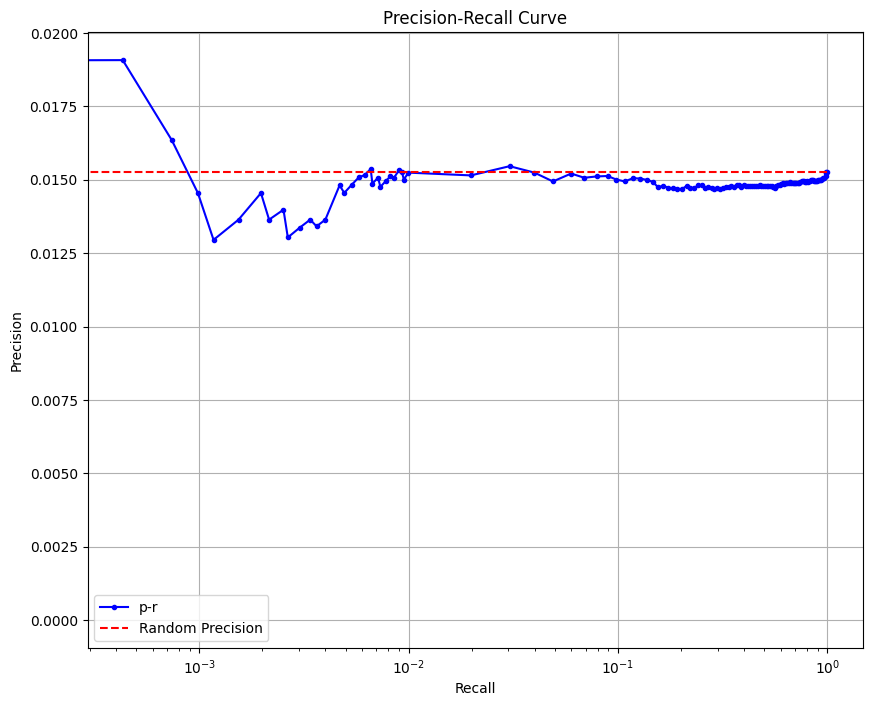

In [19]:
grn.var.index = grn.var.ensembl_id
metrics['deepsem_tf_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


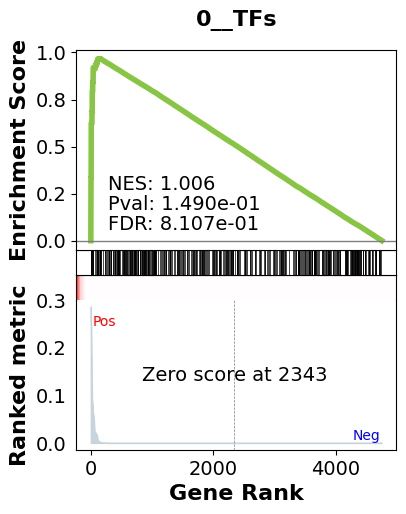

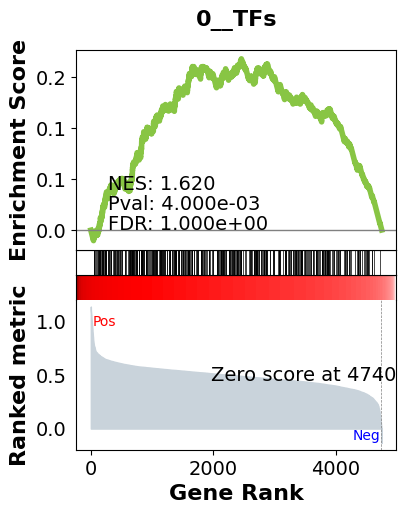

_________________________________________
TF specific enrichment
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.008116119799652459 
recall:  0.5714861518972765 
random precision: 0.0016326385571186594


 97%|█████████▋| 124/128 [00:03<00:00, 37.08it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 37.29it/s]


Average Precision (AP):  0.007037289370321671
Area Under Precision-Recall Curve (AUPRC):  0.006162395235749567
EPR: 11.902964644987264


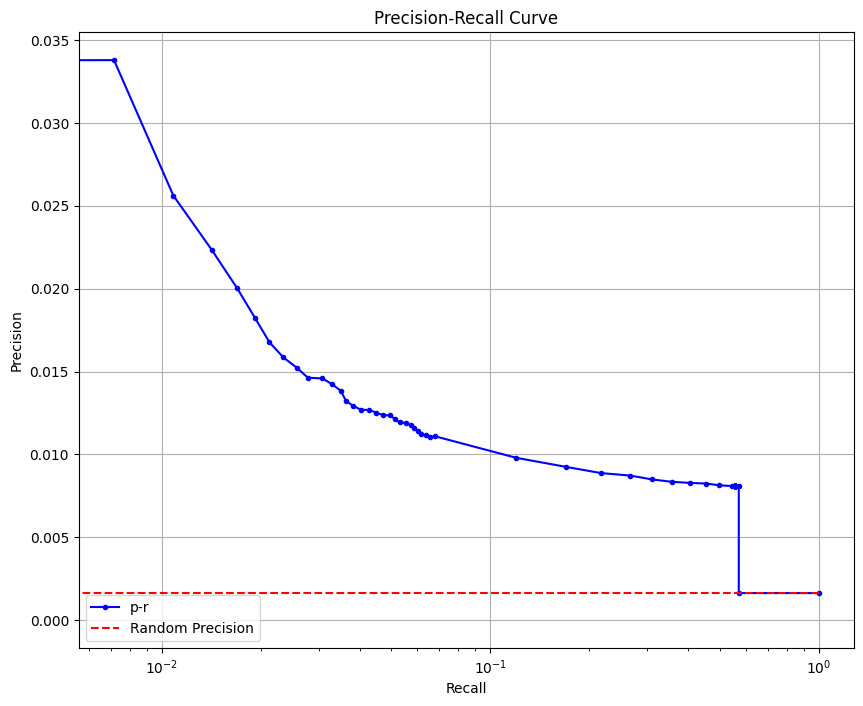

In [17]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
metrics['deepsem_tf_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [18]:
metrics

{'deepsem_perturb': {'precision': 0.020546889236634377,
  'recall': 0.9917349025849371,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.02397192958248463,
  'ap': 0.02547009448322059,
  'epr': 1.9892836984184035},
 'deepsem_perturb_base': {'TF_enr': False,
  'significant_enriched_TFtargets': 21.428571428571427,
  'precision': 0.00163245054093197,
  'recall': 0.99988483906259,
  'rand_precision': 0.0016326385571186594,
  'auprc': 0.0019222402510635618,
  'ap': 0.0019365648286373996,
  'epr': 4.132839443499634},
 'deepsem_tf_perturb': {'precision': 0.015117780354131534,
  'recall': 0.9900166389351082,
  'rand_precision': 0.015270228559383281,
  'auprc': 0.01605437070577363,
  'ap': 0.01604351372029926,
  'epr': 1.837017862110895},
 'deepsem_tf_perturb_base': {'TF_enr': False,
  'significant_enriched_TFtargets': 3.5714285714285716,
  'precision': 0.008116119799652459,
  'recall': 0.5714861518972765,
  'rand_precision': 0.0016326385571186594,
  'auprc': 0.006162395235749567,
  'ap':

In [19]:
import pandas as pd

In [20]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,perturb,1.989284,0.023972,0.020718,False
1,perturb,1.837018,0.016054,0.015270,True


In [21]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,perturb,4.132839,0.001922,0.001633,21.428571,False,False
1,perturb,11.902965,0.006162,0.001633,3.571429,False,True


: 